# Laboratorium 3 – Filtrowanie obrazów

## Cel laboratorium
Celem laboratorium jest zapoznanie się z podstawowymi technikami filtrowania obrazów, w tym:
- Filtrami konwolucyjnymi (dolnoprzepustowymi i górnoprzepustowymi)
- Filtrami wykrywania krawędzi
- Filtrami nieliniowymi (medianowymi)

---

## Sekcja 1 – Teoria

### 1.1 Filtrowanie obrazów

Filtrowanie obrazów to podstawowa operacja przetwarzania obrazów, która polega na modyfikacji wartości pikseli na podstawie ich sąsiedztwa. Filtry mogą służyć do:
- Wygładzania obrazu (usuwanie szumu)
- Wyostrzania obrazu
- Wykrywania krawędzi
- Wykrywania innych cech obrazu

### 1.2 Splot (konwolucja)

Splot to operacja matematyczna, która łączy dwie funkcje, tworząc trzecią funkcję. W kontekście przetwarzania obrazów:

$$g(x,y) = \sum_{i=-a}^{a} \sum_{j=-b}^{b} f(x+i, y+j) \cdot h(i,j)$$

gdzie:
- $f(x,y)$ – obraz wejściowy
- $h(i,j)$ – jądro (maska) filtru
- $g(x,y)$ – obraz wyjściowy

**Proces konwolucji:**
1. Umieść jądro filtru nad pikselem obrazu
2. Pomnóż odpowiadające sobie wartości
3. Zsumuj wszystkie iloczyny
4. Wynik zapisz jako nową wartość piksela
5. Przesuń jądro do kolejnego piksela

### 1.3 Filtry dolnoprzepustowe (wygładzające)

Filtry dolnoprzepustowe redukują wysokie częstotliwości w obrazie, co prowadzi do wygładzenia i usunięcia szumu.

**Filtr uśredniający (box filter):**
```
1/9 * | 1  1  1 |
      | 1  1  1 |
      | 1  1  1 |
```

**Filtr Gaussa:**
```
1/16 * | 1  2  1 |
       | 2  4  2 |
       | 1  2  1 |
```

Filtr Gaussa nadaje większą wagę pikselom bliższym centrum, co daje lepsze rezultaty niż prosty filtr uśredniający.

### 1.4 Filtry górnoprzepustowe (wyostrzające)

Filtry górnoprzepustowe wzmacniają wysokie częstotliwości, co prowadzi do wyostrzenia krawędzi.

**Filtr Laplace'a:**
```
| 0  -1   0 |
|-1   4  -1 |
| 0  -1   0 |
```

lub

```
|-1  -1  -1 |
|-1   8  -1 |
|-1  -1  -1 |
```

### 1.5 Filtry wykrywania krawędzi

**Filtr Sobela** – wykrywa krawędzie w kierunku poziomym i pionowym:

Sobel X (pionowy):
```
|-1  0  1 |
|-2  0  2 |
|-1  0  1 |
```

Sobel Y (poziomy):
```
|-1 -2 -1 |
| 0  0  0 |
| 1  2  1 |
```

Gradient można obliczyć jako: $G = \sqrt{G_x^2 + G_y^2}$

**Filtr Prewitta** – podobny do Sobela, ale z równymi wagami:

Prewitt X:
```
|-1  0  1 |
|-1  0  1 |
|-1  0  1 |
```

Prewitt Y:
```
|-1 -1 -1 |
| 0  0  0 |
| 1  1  1 |
```

### 1.6 Filtry nieliniowe – filtr medianowy

Filtr medianowy to nieliniowy filtr, który zastępuje wartość piksela medianą wartości w jego sąsiedztwie. Jest szczególnie skuteczny w usuwaniu szumu impulsowego (salt-and-pepper).

**Algorytm:**
1. Wybierz okno (np. 3×3) wokół piksela
2. Posortuj wartości pikseli w oknie
3. Wybierz wartość środkową (medianę)
4. Zastąp wartość piksela medianą

**Zalety:**
- Skutecznie usuwa szum impulsowy
- Zachowuje krawędzie lepiej niż filtry liniowe

### 1.7 Obsługa brzegów obrazu

Podczas filtrowania pikseli na brzegach obrazu, część jądra filtru wykracza poza obraz. Istnieje kilka strategii radzenia sobie z tym problemem:

1. **Zero padding** – piksele poza obrazem traktowane jako 0
2. **Replicate** – powielanie wartości brzegowych pikseli
3. **Reflect** – odbicie lustrzane obrazu
4. **Wrap** – zawijanie obrazu (lewy brzeg łączy się z prawym)
5. **Crop** – pomijanie pikseli brzegowych (zmniejszenie rozmiaru obrazu)

---

## Sekcja 2 – Kod startowy

### 2.1 Import bibliotek

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen

# Konfiguracja wyświetlania
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

### 2.2 Funkcje pomocnicze

In [5]:
def rgb_to_gray(image):
    """
    Konwertuje obraz RGB do skali szarości.
    
    Parametry:
    image (numpy.ndarray): Obraz RGB
    
    Zwraca:
    numpy.ndarray: Obraz w skali szarości
    """
    if len(image.shape) == 3:
        # Wzór: Y = 0.299*R + 0.587*G + 0.114*B
        return np.dot(image[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    return image

def display_images(images, titles, cmap='gray', figsize=(15, 5)):
    """
    Wyświetla wiele obrazów obok siebie.
    
    Parametry:
    images (list): Lista obrazów do wyświetlenia
    titles (list): Lista tytułów dla każdego obrazu
    cmap (str): Mapa kolorów (domyślnie 'gray')
    figsize (tuple): Rozmiar figury
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

### 2.3 Wczytanie obrazu testowego

Rozmiar obrazu Lenna: (100, 100)
Typ danych: uint8
Zakres wartości: [14, 242]


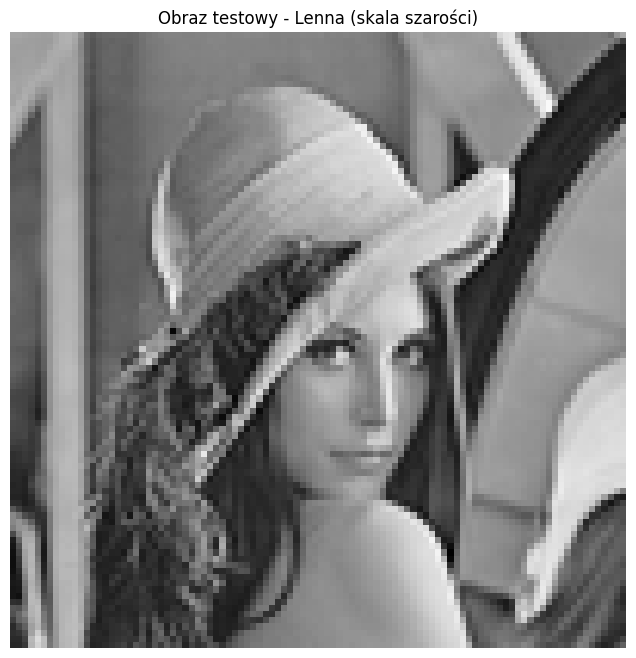

In [73]:
# Wczytanie obrazu testowego z GitHub
url_lenna = 'https://raw.githubusercontent.com/kbor89/TWiPO/main/images/lenna.png'

# Wczytanie obrazu z URL
img_lenna = np.array(Image.open(urlopen(url_lenna)))

# Konwersja do skali szarości
img_lenna_gray = rgb_to_gray(img_lenna).astype(np.uint8)

# Zmniejszenie obrazu do 100x100
img_lenna_gray = np.array(Image.fromarray(img_lenna_gray).resize((100, 100), Image.LANCZOS))


print(f"Rozmiar obrazu Lenna: {img_lenna_gray.shape}")
print(f"Typ danych: {img_lenna_gray.dtype}")
print(f"Zakres wartości: [{img_lenna_gray.min()}, {img_lenna_gray.max()}]")

# Wyświetlenie
plt.figure(figsize=(8, 8))
plt.imshow(img_lenna_gray, cmap='gray')
plt.title('Obraz testowy - Lenna (skala szarości)')
plt.axis('off')
plt.show()

### 2.4 Generowanie obrazu z szumem

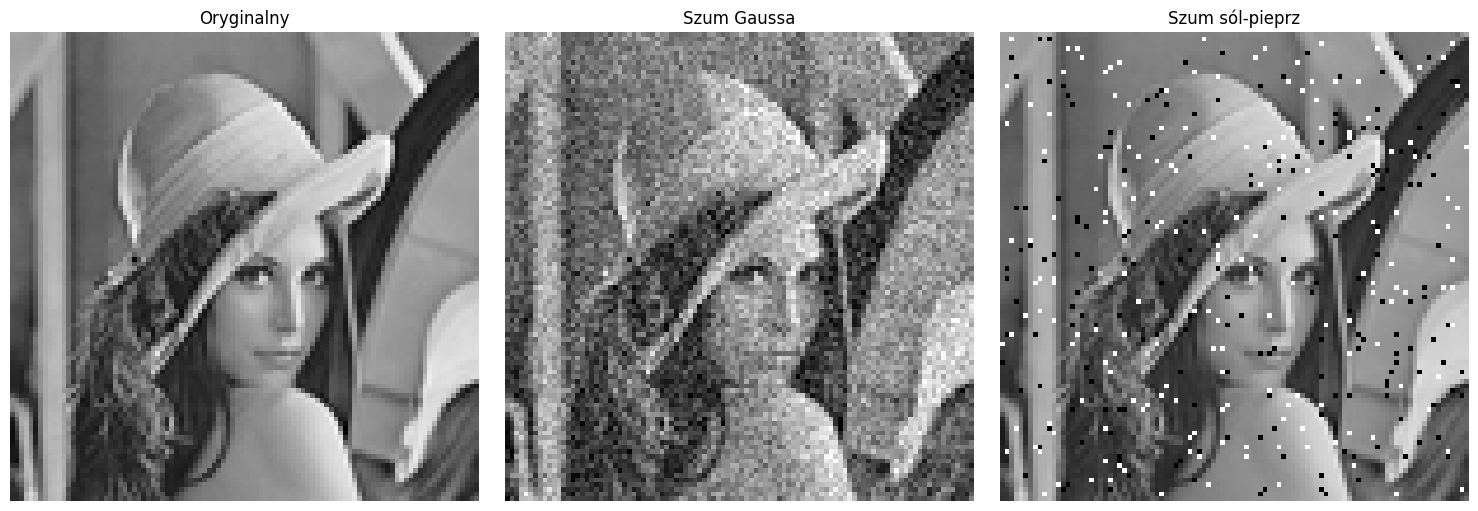

In [74]:
def add_gaussian_noise(image, mean=0, sigma=25):
    """
    Dodaje szum Gaussa do obrazu.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    mean (float): Średnia szumu
    sigma (float): Odchylenie standardowe szumu
    
    Zwraca:
    numpy.ndarray: Obraz z szumem
    """
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """
    Dodaje szum typu "sól i pieprz" do obrazu.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    salt_prob (float): Prawdopodobieństwo białego piksela
    pepper_prob (float): Prawdopodobieństwo czarnego piksela
    
    Zwraca:
    numpy.ndarray: Obraz z szumem
    """
    noisy_image = image.copy()
    
    # Sól (białe piksele)
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 255
    
    # Pieprz (czarne piksele)
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0
    
    return noisy_image

# Przykłady użycia
img_gaussian_noise = add_gaussian_noise(img_lenna_gray, sigma=20)
img_salt_pepper = add_salt_pepper_noise(img_lenna_gray, salt_prob=0.02, pepper_prob=0.02)

display_images(
    [img_lenna_gray, img_gaussian_noise, img_salt_pepper],
    ['Oryginalny', 'Szum Gaussa', 'Szum sól-pieprz']
)

---
## Sekcja 3 – Zadania do wykonania

### Zadanie 1: Implementacja funkcji konwolucji

Zaimplementuj funkcję `convolve2d`, która wykonuje operację splotu 2D na obrazie.

**Wymagania:**
- Funkcja przyjmuje obraz i jądro filtru
- Obsługuje obrazy w skali szarości (2D)
- Implementuje obsługę brzegów (zero padding)
- Zwraca przefiltrowany obraz

**Wskazówki:**
- Użyj pętli do iteracji po pikselach obrazu
- Dla każdego piksela: pomnóż wartości z jądrem i zsumuj
- Możesz użyć `np.pad()` do dodania ramki wokół obrazu

In [18]:
def convolve2d(image, kernel, padding='zero'):
    """
    Wykonuje operację splotu 2D na obrazie.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy (2D)
    kernel (numpy.ndarray): Jądro filtru (2D)
    padding (str): Typ paddingu ('zero', 'replicate', 'reflect')
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # TODO: Zaimplementuj funkcję konwolucji
    pass

In [75]:
def convolve2d(image, kernel, padding='zero'):
    """
    Wykonuje operację splotu 2D na obrazie.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy (2D)
    kernel (numpy.ndarray): Jądro filtru (2D)
    padding (str): Typ paddingu ('zero', 'replicate', 'reflect')
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # Rozmiary obrazu i jądra
    img_rows, img_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape
    
    # Obliczenie paddingu
    pad_rows = kernel_rows // 2
    pad_cols = kernel_cols // 2
    
    # Dodanie paddingu do obrazu
    if padding == 'zero':
        padded = np.pad(image, ((pad_rows, pad_rows), (pad_cols, pad_cols)), 
                       mode='constant', constant_values=0)
    elif padding == 'replicate':
        padded = np.pad(image, ((pad_rows, pad_rows), (pad_cols, pad_cols)), 
                       mode='edge')
    elif padding == 'reflect':
        padded = np.pad(image, ((pad_rows, pad_rows), (pad_cols, pad_cols)), 
                       mode='reflect')
    else:
        raise ValueError(f"Nieznany typ paddingu: {padding}")
    
    # Inicjalizacja obrazu wynikowego
    result = np.zeros_like(image, dtype=np.float64)
    
    # Operacja splotu
    for i in range(img_rows):
        for j in range(img_cols):
            # Wyciągnięcie okna z obrazu
            window = padded[i:i+kernel_rows, j:j+kernel_cols]
            
            # Obliczenie splotu (suma iloczynów element po elemencie)
            result[i, j] = np.sum(window * kernel)
    
    return result

#### Test Zadania 1
Przetestuj swoją implementację konwolucji:

Test 1a - Filtr identycznościowy:
Czy obraz pozostał niezmieniony? True

Test 1b - Filtr uśredniający:
Rozmiar obrazu wyjściowego: (100, 100)
Typ danych: float64
Zakres wartości: [203.0, 1965.0]


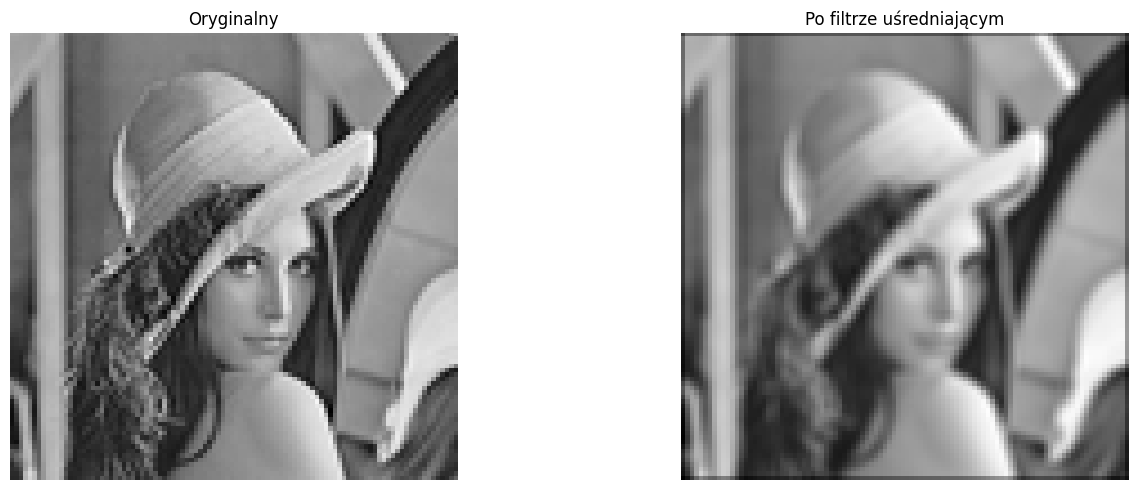

In [76]:
# Test 1a: Filtr identycznościowy
identity_kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
], dtype=np.float32)

img_identity = convolve2d(img_lenna_gray, identity_kernel)
print("Test 1a - Filtr identycznościowy:")
print(f"Czy obraz pozostał niezmieniony? {np.allclose(img_lenna_gray[1:-1, 1:-1], img_identity[1:-1, 1:-1], atol=1)}")

# Test 1b: Prosty filtr uśredniający 3x3
kernel_avg = np.ones((3, 3))
img_filtered = convolve2d(img_lenna_gray, kernel_avg)

print("\nTest 1b - Filtr uśredniający:")
print(f"Rozmiar obrazu wyjściowego: {img_filtered.shape}")
print(f"Typ danych: {img_filtered.dtype}")
print(f"Zakres wartości: [{img_filtered.min():.1f}, {img_filtered.max():.1f}]")

display_images([img_lenna_gray, img_filtered], ['Oryginalny', 'Po filtrze uśredniającym'])

### Zadanie 2: Filtry dolnoprzepustowe

Zaimplementuj funkcje tworzące jądra filtrów dolnoprzepustowych:
- `create_box_filter(size)` – filtr uśredniający
- `create_gaussian_filter(size, sigma)` – filtr Gaussa

Następnie zastosuj te filtry do obrazu z szumem Gaussa i porównaj wyniki.

**Wzór na filtr Gaussa:**
$$G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

In [ ]:
def create_box_filter(size):
    """
    Tworzy jądro filtru uśredniającego.
    
    Parametry:
    size (int): Rozmiar jądra (nieparzysta liczba)
    
    Zwraca:
    numpy.ndarray: Jądro filtru
    """
    # TODO: Zaimplementuj
    pass

def create_gaussian_filter(size, sigma):
    """
    Tworzy jądro filtru Gaussa.
    
    Parametry:
    size (int): Rozmiar jądra (nieparzysta liczba)
    sigma (float): Odchylenie standardowe
    
    Zwraca:
    numpy.ndarray: Jądro filtru
    """
    # TODO: Zaimplementuj
    pass

In [57]:
def create_box_filter(size):
    """
    Tworzy jądro filtru uśredniającego.
    
    Parametry:
    size (int): Rozmiar jądra (nieparzysta liczba)
    
    Zwraca:
    numpy.ndarray: Jądro filtru
    """
    # Sprawdzenie czy rozmiar jest nieparzysty
    if size % 2 == 0:
        raise ValueError("Rozmiar jądra musi być liczbą nieparzystą")
    
    # Utworzenie macierzy wypełnionej jedynkami
    kernel = np.ones((size, size), dtype=np.float64)
    
    # Normalizacja - suma elementów = 1
    kernel = kernel / (size * size)
    
    return kernel


def create_gaussian_filter(size, sigma):
    """
    Tworzy jądro filtru Gaussa.
    
    Parametry:
    size (int): Rozmiar jądra (nieparzysta liczba)
    sigma (float): Odchylenie standardowe
    
    Zwraca:
    numpy.ndarray: Jądro filtru
    """
    # Sprawdzenie czy rozmiar jest nieparzysty
    if size % 2 == 0:
        raise ValueError("Rozmiar jądra musi być liczbą nieparzystą")
    
    # Sprawdzenie czy sigma jest dodatnia
    if sigma <= 0:
        raise ValueError("Sigma musi być liczbą dodatnią")
    
    # Utworzenie siatki współrzędnych
    # Dla size=5: ax = [-2, -1, 0, 1, 2]
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    
    # Utworzenie siatki 2D
    xx, yy = np.meshgrid(ax, ax)
    
    # Obliczenie wartości funkcji Gaussa dla każdego punktu
    # G(x,y) = exp(-(x^2 + y^2) / (2*sigma^2))
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    
    # Normalizacja - suma elementów = 1
    kernel = kernel / np.sum(kernel)
    
    return kernel

#### Test Zadania 2
Przetestuj filtry dolnoprzepustowe:

Test 2a - Właściwości jąder:
Suma elementów box filter: 1.000000 (powinno być ≈1.0)
Suma elementów Gaussian filter: 1.000000 (powinno być ≈1.0)
Rozmiar box kernel: (3, 3)
Rozmiar Gaussian kernel: (3, 3)


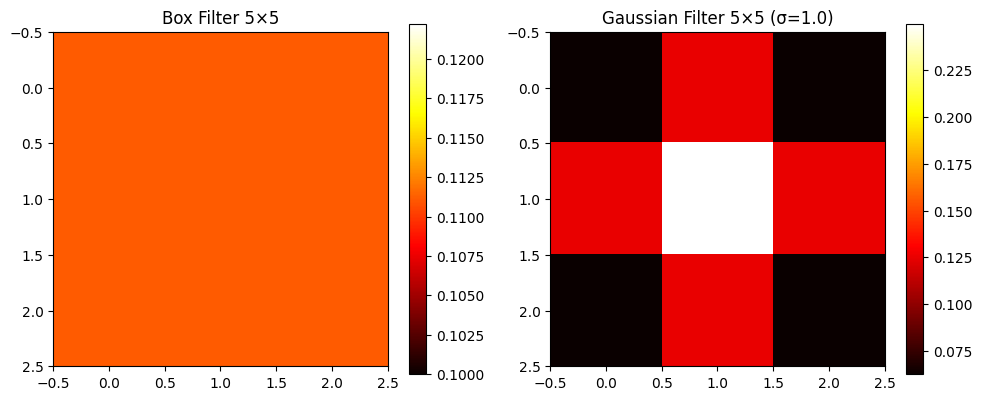


Test 2b - Filtrowanie obrazu z szumem:


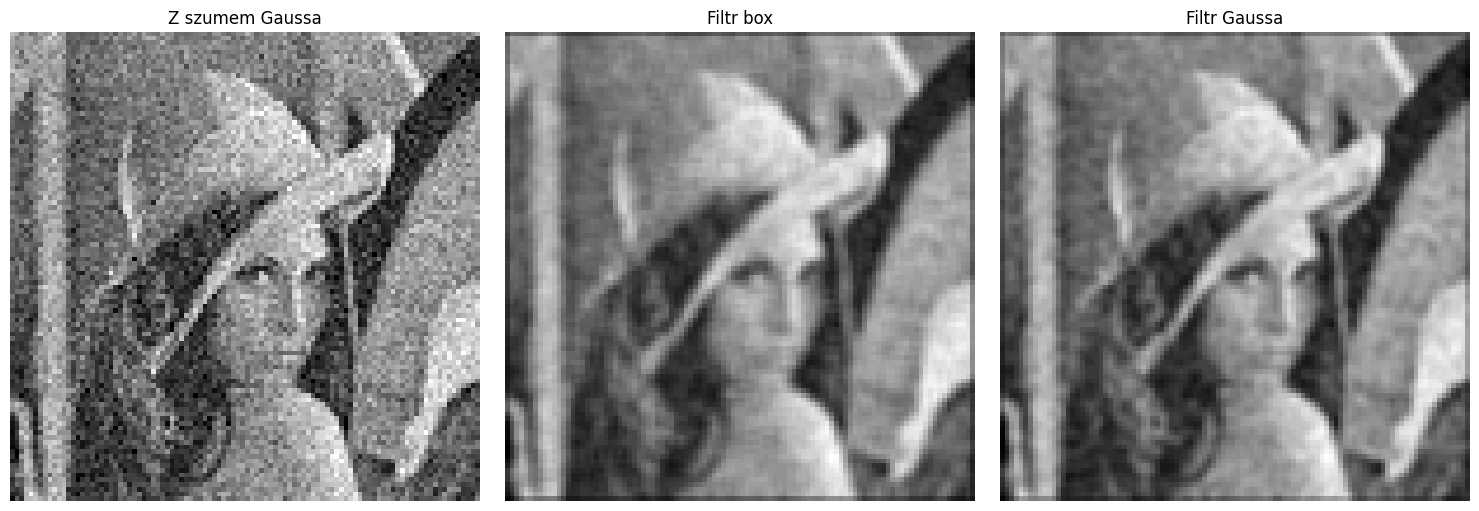

In [89]:
# Test 2a: Sprawdzenie poprawności jąder
box_kernel = create_box_filter(3)
gaussian_kernel = create_gaussian_filter(3, 0.85)

print("Test 2a - Właściwości jąder:")
print(f"Suma elementów box filter: {box_kernel.sum():.6f} (powinno być ≈1.0)")
print(f"Suma elementów Gaussian filter: {gaussian_kernel.sum():.6f} (powinno być ≈1.0)")
print(f"Rozmiar box kernel: {box_kernel.shape}")
print(f"Rozmiar Gaussian kernel: {gaussian_kernel.shape}")

# Wizualizacja jąder
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im1 = axes[0].imshow(box_kernel, cmap='hot', interpolation='nearest')
axes[0].set_title('Box Filter 5×5')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(gaussian_kernel, cmap='hot', interpolation='nearest')
axes[1].set_title('Gaussian Filter 5×5 (σ=1.0)')
plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

# Test 2b: Zastosowanie filtrów do obrazu z szumem
img_box = convolve2d(img_gaussian_noise, box_kernel)
img_gaussian = convolve2d(img_gaussian_noise, gaussian_kernel)

print("\nTest 2b - Filtrowanie obrazu z szumem:")
display_images([img_gaussian_noise, img_box, img_gaussian], 
               ['Z szumem Gaussa', 'Filtr box', 'Filtr Gaussa'])

### Zadanie 3: Filtry wykrywania krawędzi

Zaimplementuj funkcje wykrywania krawędzi:
- `sobel_filter(image)` – zwraca gradient (magnitude) i kierunek
- `prewitt_filter(image)` – zwraca gradient (magnitude)
- `laplacian_filter(image)` – zwraca wynik filtracji Laplace'a

**Wskazówki:**
- Dla Sobela i Prewitta: oblicz gradient w kierunku X i Y osobno
- Magnitude: $G = \sqrt{G_x^2 + G_y^2}$
- Kierunek: $\theta = \arctan(G_y / G_x)$

In [60]:
def sobel_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Sobela.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    tuple: (magnitude, direction) - gradient i kierunek
    """
    # TODO: Zaimplementuj
    pass

def prewitt_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Prewitta.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    numpy.ndarray: Gradient (magnitude)
    """
    # TODO: Zaimplementuj
    pass

def laplacian_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Laplace'a.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # TODO: Zaimplementuj
    pass

In [90]:
def sobel_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Sobela.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    tuple: (magnitude, direction) - gradient i kierunek
    """
    # Jądra Sobela
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float64)
    
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float64)
    
    # Obliczenie gradientów w kierunkach x i y
    gradient_x = convolve2d(image, sobel_x, padding='reflect')
    gradient_y = convolve2d(image, sobel_y, padding='reflect')
    
    # Obliczenie magnitude (siły gradientu)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Obliczenie kierunku gradientu (w radianach)
    direction = np.arctan2(gradient_y, gradient_x)
    
    return magnitude, direction


def prewitt_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Prewitta.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    numpy.ndarray: Gradient (magnitude)
    """
    # Jądra Prewitta
    prewitt_x = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]], dtype=np.float64)
    
    prewitt_y = np.array([[-1, -1, -1],
                          [ 0,  0,  0],
                          [ 1,  1,  1]], dtype=np.float64)
    
    # Obliczenie gradientów w kierunkach x i y
    gradient_x = convolve2d(image, prewitt_x, padding='reflect')
    gradient_y = convolve2d(image, prewitt_y, padding='reflect')
    
    # Obliczenie magnitude (siły gradientu)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    return magnitude


def laplacian_filter(image):
    """
    Wykrywa krawędzie za pomocą filtru Laplace'a.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # Jądro Laplace'a (wersja 4-sąsiedztwa)
    laplacian_kernel = np.array([[ 0, -1,  0],
                                 [-1,  4, -1],
                                 [ 0, -1,  0]], dtype=np.float64)
    
    # Alternatywnie: wersja 8-sąsiedztwa
    # laplacian_kernel = np.array([[-1, -1, -1],
    #                              [-1,  8, -1],
    #                              [-1, -1, -1]], dtype=np.float64)
    
    # Konwolucja
    result = convolve2d(image, laplacian_kernel, padding='reflect')
    
    return result

#### Test Zadania 3
Przetestuj filtry wykrywania krawędzi:

Test 3a - Filtr Sobela:
Rozmiar magnitude: (100, 100)
Zakres magnitude: [0.0, 862.0]
Rozmiar direction: (100, 100)
Zakres direction: [-3.14, 3.14] (radiany)

Test 3b - Filtr Prewitta:
Rozmiar: (100, 100)
Zakres: [0.0, 622.1]

Test 3c - Filtr Laplace'a:
Rozmiar: (100, 100)
Zakres: [-316.0, 339.0]


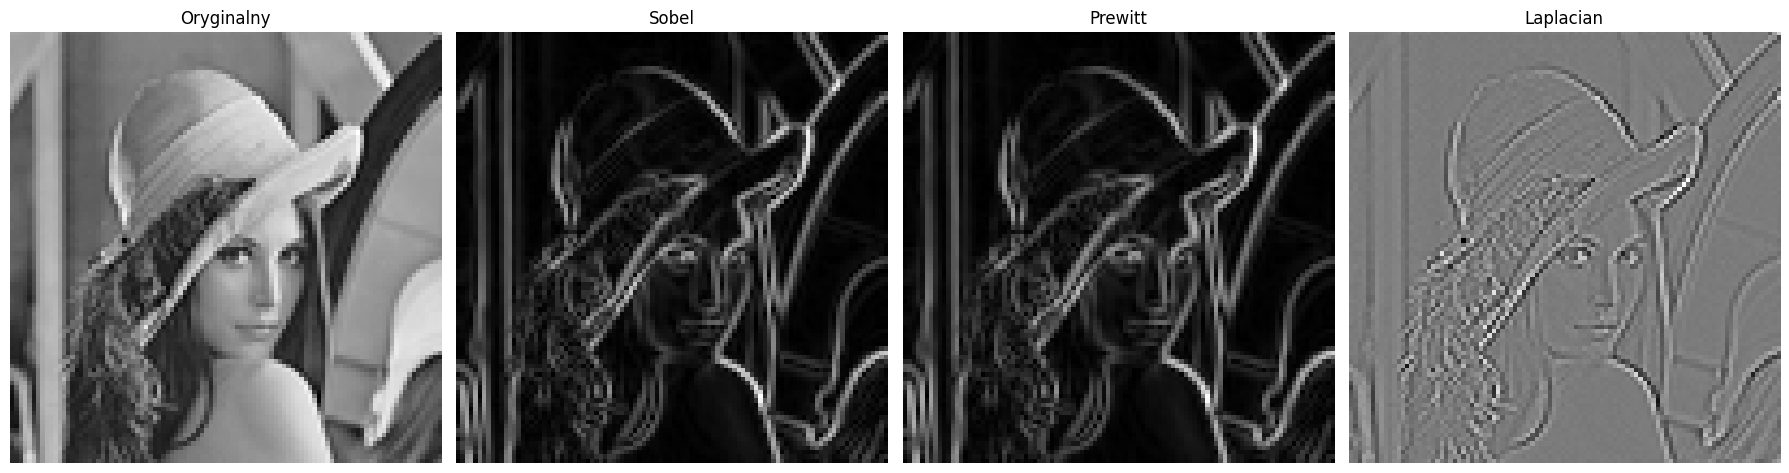

In [91]:
# Test 3a: Sobel filter
sobel_mag, sobel_dir = sobel_filter(img_lenna_gray)

print("Test 3a - Filtr Sobela:")
print(f"Rozmiar magnitude: {sobel_mag.shape}")
print(f"Zakres magnitude: [{sobel_mag.min():.1f}, {sobel_mag.max():.1f}]")
print(f"Rozmiar direction: {sobel_dir.shape}")
print(f"Zakres direction: [{sobel_dir.min():.2f}, {sobel_dir.max():.2f}] (radiany)")

# Test 3b: Prewitt filter
prewitt_mag = prewitt_filter(img_lenna_gray)

print("\nTest 3b - Filtr Prewitta:")
print(f"Rozmiar: {prewitt_mag.shape}")
print(f"Zakres: [{prewitt_mag.min():.1f}, {prewitt_mag.max():.1f}]")

# Test 3c: Laplacian filter
laplacian = laplacian_filter(img_lenna_gray)

print("\nTest 3c - Filtr Laplace'a:")
print(f"Rozmiar: {laplacian.shape}")
print(f"Zakres: [{laplacian.min():.1f}, {laplacian.max():.1f}]")

# Wizualizacja wszystkich filtrów
display_images([img_lenna_gray, sobel_mag, prewitt_mag, laplacian],
               ['Oryginalny', 'Sobel', 'Prewitt', 'Laplacian'],
               figsize=(18, 5))

### Zadanie 4: Filtr medianowy

Zaimplementuj funkcję `median_filter(image, size)`, która wykonuje filtrację medianową.

**Wymagania:**
- Funkcja przyjmuje obraz i rozmiar okna
- Dla każdego piksela: pobierz wartości z sąsiedztwa, posortuj i wybierz medianę
- Zastosuj filtr do obrazu z szumem "sól-pieprz" i porównaj z filtrem Gaussa

**Wskazówka:** Użyj `np.median()` lub `np.sort()` do znalezienia mediany.

In [ ]:
def median_filter(image, size=3):
    """
    Wykonuje filtrację medianową.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    size (int): Rozmiar okna (nieparzysta liczba)
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # TODO: Zaimplementuj
    pass

In [70]:
def median_filter(image, size=3):
    """
    Wykonuje filtrację medianową.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    size (int): Rozmiar okna (nieparzysta liczba)
    
    Zwraca:
    numpy.ndarray: Przefiltrowany obraz
    """
    # Sprawdzenie czy rozmiar jest nieparzysty
    if size % 2 == 0:
        raise ValueError("Rozmiar okna musi być liczbą nieparzystą")
    
    # Rozmiary obrazu
    rows, cols = image.shape
    
    # Obliczenie paddingu
    pad = size // 2
    
    # Padding obrazu (odbicie lustrzane)
    padded = np.pad(image, pad)
     # Padding obrazu (odbicie lustrzane)
     # padded = np.pad(image, pad, mode='reflect')
    
    # Inicjalizacja obrazu wynikowego
    result = np.zeros_like(image, dtype=image.dtype)
    
    # Filtracja medianowa
    for i in range(rows):
        for j in range(cols):
            # Wyciągnięcie okna
            window = padded[i:i+size, j:j+size]
            
            # Obliczenie mediany
            result[i, j] = np.median(window)
    
    return result

#### Test Zadania 4
Przetestuj filtr medianowy:

Test 4a - Filtr medianowy:
Rozmiar: (512, 512)
Typ danych: uint8
Zakres: [0, 238]

Test 4b - Porównanie filtrów na szumie sól-pieprz:


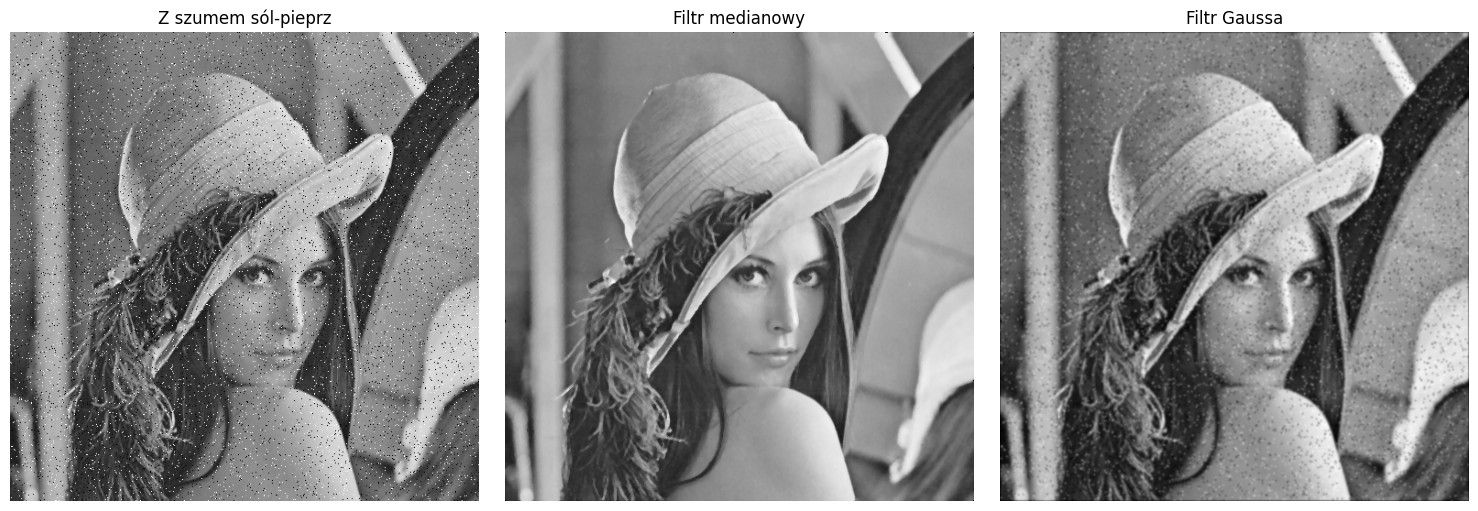


Test 4c - Wpływ rozmiaru okna:


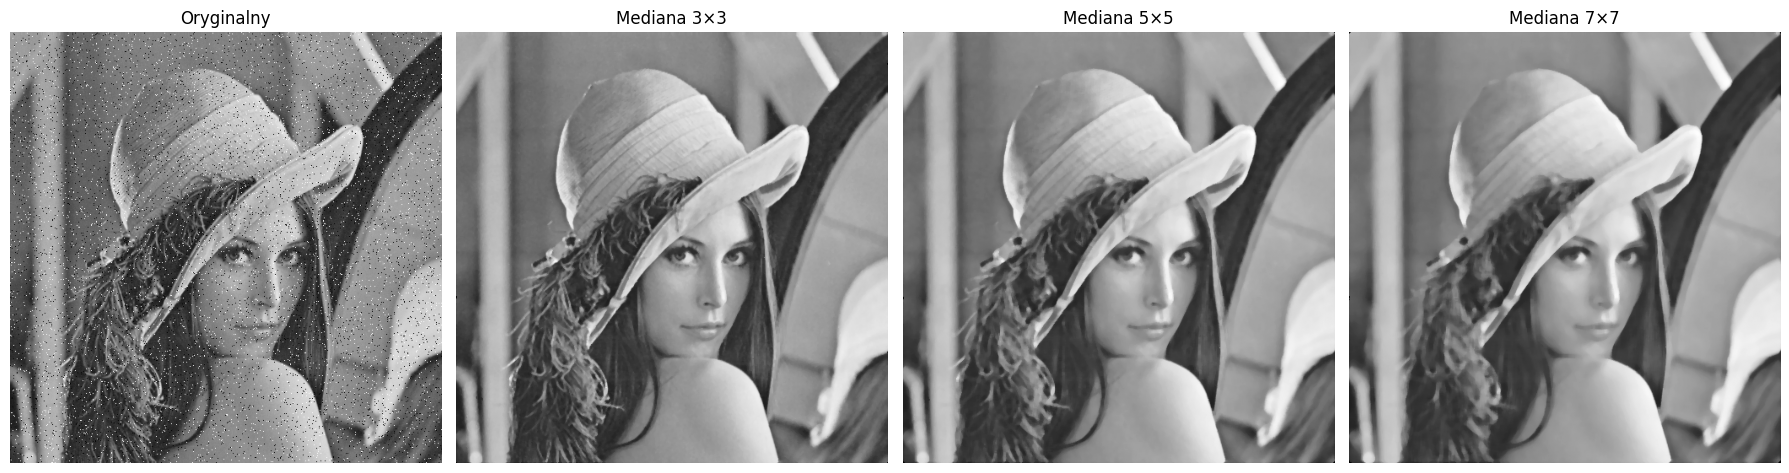

In [71]:
# Test 4a: Filtr medianowy na szumie sól-pieprz
img_median = median_filter(img_salt_pepper, size=3)

print("Test 4a - Filtr medianowy:")
print(f"Rozmiar: {img_median.shape}")
print(f"Typ danych: {img_median.dtype}")
print(f"Zakres: [{img_median.min()}, {img_median.max()}]")

# Test 4b: Porównanie z filtrem Gaussa
gaussian_kernel = create_gaussian_filter(5, 1.0)
img_gaussian_sp = convolve2d(img_salt_pepper, gaussian_kernel)

print("\nTest 4b - Porównanie filtrów na szumie sól-pieprz:")
display_images([img_salt_pepper, img_median, img_gaussian_sp],
               ['Z szumem sól-pieprz', 'Filtr medianowy', 'Filtr Gaussa'])

# Test 4c: Różne rozmiary okna
img_median_3 = median_filter(img_salt_pepper, size=3)
img_median_5 = median_filter(img_salt_pepper, size=5)
img_median_7 = median_filter(img_salt_pepper, size=7)

print("\nTest 4c - Wpływ rozmiaru okna:")
display_images([img_salt_pepper, img_median_3, img_median_5, img_median_7],
               ['Oryginalny', 'Mediana 3×3', 'Mediana 5×5', 'Mediana 7×7'],
               figsize=(18, 5))

### Zadanie 5 (**DODATKOWE**): Wyostrzanie obrazu

Zaimplementuj funkcję `sharpen_image(image, method='laplacian', k=1.0)`, która wyostrza obraz.

**Metody wyostrzania:**
1. **Laplacian sharpening:** `sharpened = original + k * laplacian(original)`
2. **Unsharp masking:** `sharpened = original + k * (original - blurred)`

gdzie `k` to współczynnik wyostrzania (np. 0.5-2.0).

**Wymagania:**
- Zaimplementuj obie metody
- Porównaj wyniki dla różnych wartości `k`
- Zadbaj o prawidłowy zakres wartości pikseli (0-255)

In [ ]:
def sharpen_image(image, method='laplacian', k=1.0):
    """
    Wyostrza obraz.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    method (str): Metoda wyostrzania ('laplacian' lub 'unsharp')
    k (float): Współczynnik wyostrzania
    
    Zwraca:
    numpy.ndarray: Wyostrzony obraz
    """
    # TODO: Zaimplementuj
    pass

In [92]:
def sharpen_image(image, method='laplacian', k=1.0):
    """
    Wyostrza obraz.
    
    Parametry:
    image (numpy.ndarray): Obraz wejściowy
    method (str): Metoda wyostrzania ('laplacian' lub 'unsharp')
    k (float): Współczynnik wyostrzania
    
    Zwraca:
    numpy.ndarray: Wyostrzony obraz
    """
    if method == 'laplacian':
        # Metoda Laplacian sharpening
        # Sharpened = Original + k * Laplacian(Original)
        
        # Jądro Laplace'a
        laplacian_kernel = np.array([[ 0, -1,  0],
                                     [-1,  4, -1],
                                     [ 0, -1,  0]], dtype=np.float64)
        
        # Obliczenie Laplacianu
        laplacian = convolve2d(image, laplacian_kernel, padding='reflect')
        
        # Wyostrzenie
        sharpened = image + k * laplacian
        
    elif method == 'unsharp':
        # Metoda Unsharp Masking
        # Sharpened = Original + k * (Original - Blurred)
        
        # Wygładzenie obrazu filtrem Gaussa
        gaussian_kernel = create_gaussian_filter(size=5, sigma=1.0)
        blurred = convolve2d(image, gaussian_kernel, padding='reflect')
        
        # Maska wyostrzająca (różnica między oryginałem a rozmytym)
        unsharp_mask = image - blurred
        
        # Wyostrzenie
        sharpened = image + k * unsharp_mask
        
    else:
        raise ValueError(f"Nieznana metoda: {method}. Dostępne: 'laplacian', 'unsharp'")
    
    # Ograniczenie wartości do zakresu [0, 255]
    sharpened = np.clip(sharpened, 0, 255)
    
    return sharpened.astype(image.dtype)

#### Test Zadania 5
Przetestuj wyostrzanie obrazu:

Test 5a - Laplacian sharpening:
Rozmiar: (100, 100)
Typ danych: uint8
Zakres: [0, 255]

Test 5b - Unsharp masking:
Rozmiar: (100, 100)
Typ danych: uint8
Zakres: [0, 255]


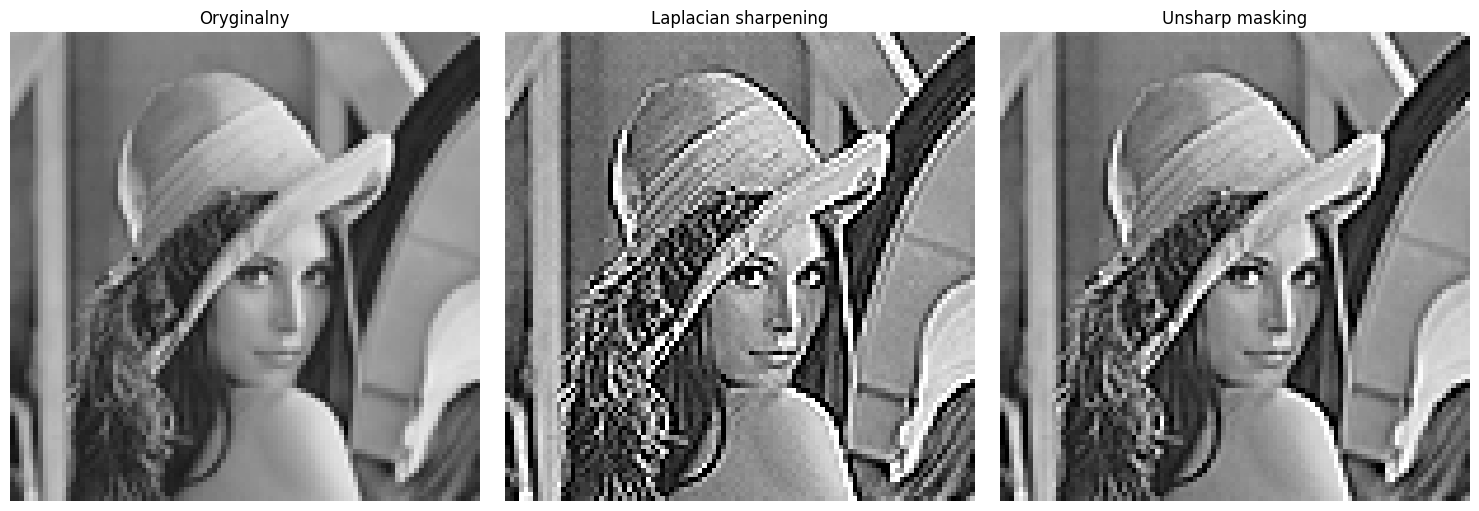


Test 5c - Wpływ współczynnika k:


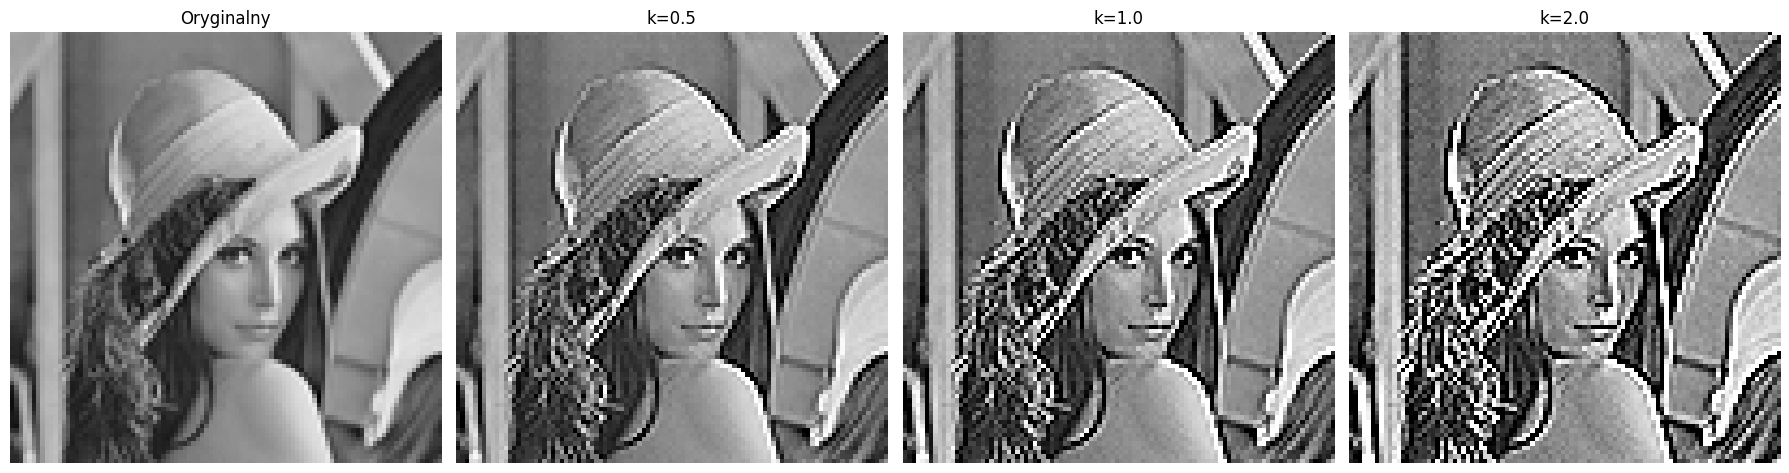

In [93]:
# Test 5a: Laplacian sharpening
img_sharp_lap = sharpen_image(img_lenna_gray, method='laplacian', k=1.0)

print("Test 5a - Laplacian sharpening:")
print(f"Rozmiar: {img_sharp_lap.shape}")
print(f"Typ danych: {img_sharp_lap.dtype}")
print(f"Zakres: [{img_sharp_lap.min()}, {img_sharp_lap.max()}]")

# Test 5b: Unsharp masking
img_sharp_unsharp = sharpen_image(img_lenna_gray, method='unsharp', k=1.5)

print("\nTest 5b - Unsharp masking:")
print(f"Rozmiar: {img_sharp_unsharp.shape}")
print(f"Typ danych: {img_sharp_unsharp.dtype}")
print(f"Zakres: [{img_sharp_unsharp.min()}, {img_sharp_unsharp.max()}]")

display_images([img_lenna_gray, img_sharp_lap, img_sharp_unsharp],
               ['Oryginalny', 'Laplacian sharpening', 'Unsharp masking'])

# Test 5c: Różne wartości współczynnika k
img_sharp_k05 = sharpen_image(img_lenna_gray, method='laplacian', k=0.5)
img_sharp_k10 = sharpen_image(img_lenna_gray, method='laplacian', k=1.0)
img_sharp_k20 = sharpen_image(img_lenna_gray, method='laplacian', k=2.0)

print("\nTest 5c - Wpływ współczynnika k:")
display_images([img_lenna_gray, img_sharp_k05, img_sharp_k10, img_sharp_k20],
               ['Oryginalny', 'k=0.5', 'k=1.0', 'k=2.0'],
               figsize=(18, 5))

### Zadanie 6: Analiza porównawcza

Przeprowadź analizę porównawczą różnych filtrów:

1. **Porównanie filtrów wygładzających:**
   - Zastosuj filtry: box (3×3, 5×5, 7×7), Gaussian (różne σ), medianowy
   - Użyj obrazu z szumem Gaussa
   - Oceń wizualnie jakość usunięcia szumu

2. **Porównanie filtrów wykrywania krawędzi:**
   - Zastosuj: Sobel, Prewitt, Laplacian
   - Porównaj wyniki na tym samym obrazie
   - Który filtr najlepiej wykrywa krawędzie?

3. **Wpływ rozmiaru jądra:**
   - Przetestuj filtry o różnych rozmiarach (3×3, 5×5, 7×7, 9×9)
   - Jak rozmiar wpływa na wynik?

Przedstaw wyniki w formie wizualizacji i krótkiego opisu.

In [ ]:
# TODO: Przeprowadź analizę porównawczą

# Analiza 1: Porównanie filtrów wygładzających
print("=" * 60)
print("ANALIZA 1: Porównanie filtrów wygładzających")
print("=" * 60)

# TODO: Zaimplementuj porównanie
# Przykładowa struktura:
# - Utwórz filtry różnych rozmiarów
# - Zastosuj do obrazu z szumem
# - Wyświetl wyniki
# - Opisz obserwacje

# Analiza 2: Porównanie filtrów wykrywania krawędzi
print("\n" + "=" * 60)
print("ANALIZA 2: Porównanie filtrów wykrywania krawędzi")
print("=" * 60)

# TODO: Zaimplementuj porównanie

# Analiza 3: Wpływ rozmiaru jądra
print("\n" + "=" * 60)
print("ANALIZA 3: Wpływ rozmiaru jądra")
print("=" * 60)

# TODO: Zaimplementuj porównanie

#### Test Zadania 6
Sprawdź czy analiza została przeprowadzona poprawnie:

- Czy porównano co najmniej 3 filtry wygładzające?
- Czy porównano wszystkie 3 filtry wykrywania krawędzi (Sobel, Prewitt, Laplacian)?
- Czy przetestowano co najmniej 3 różne rozmiary jądra?
- Czy wyniki są zwizualizowane?
- Czy dodano opis obserwacji?

---

### Dodatkowe materiały
- [OpenCV - Image Filtering](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)
- [Scipy - Multidimensional image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Digital Image Processing - Gonzalez & Woods](https://www.imageprocessingplace.com/)

### Pytania do przemyślenia
1. Dlaczego filtr medianowy lepiej radzi sobie z szumem impulsowym niż filtr Gaussa?
2. Jaka jest różnica między konwolucją a korelacją?
3. Dlaczego filtry wykrywania krawędzi często dają lepsze wyniki na obrazach wygładzonych?
4. Jak rozmiar jądra filtru wpływa na czas obliczeń?
5. Czy można połączyć kilka filtrów w jeden? Jakie są zalety i wady takiego podejścia?